In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pickle
np.set_printoptions(suppress=True)

from models import DeepConditionalModel, InvariantNetwork
from inn_utils import train_loop_active, compute_metrics
from process_models import simulate_diffusion
from viz import plot_true_est_scatter, plot_true_est_posterior, plot_losses, plot_sbc, plot_metrics, plot_variance

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
tf.enable_eager_execution()

In [3]:
%load_ext autoreload
%autoreload 2

# Initialization 

In [4]:
def index_parameters(X_batch, theta_batch, indices):
    """
    Indexes only the relevant Levy parameters.
    """
    
    theta_batch = tf.gather(theta_batch, indices, axis=1)
    return X_batch, theta_batch

In [5]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}

parameter_bounds = {
        'v1': [0.0, 6.0],
        'v2': [-6.0, 0.0],
        'sv': [0.0, 0.0],
        'zr': [0.3, 0.7],
        'szr': [0.0, 0.0],
        'a': [0.6, 3.0],
        'ndt': [0.3, 1.0],
        'sndt': [0.0, 0.0],
        'alpha': [1.0, 2.0],
    }


# --- Training hyperparameters --- #
train = False
param_names = [r'$v_{1}$', r'$v_{2}$', r'$zr$', r'$a$', r'$t_{0}$', r'$\alpha$']
param_indices = [0, 1, 3, 5, 6, 8]
theta_dim = 6
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 32
summary_dim = 128
epochs = 100
iterations_per_epoch = 1000
n_test2 = 3
n_inv_blocks = 10
n_test = 300
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 4000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)

In [6]:
data_generator = partial(simulate_diffusion, pbounds=parameter_bounds)
transform = partial(index_parameters, indices=param_indices)

## Create a test set

In [7]:
# # For scatter
X_test, theta_test = simulate_diffusion(n_test, parameter_bounds, n_points=1000)
X_test, theta_test = transform(X_test, theta_test)

In [20]:
# For density
X_test2, theta_test2 = simulate_diffusion(n_test2, parameter_bounds, n_points=1000)
X_test2, theta_test2 = transform(X_test2, theta_test2)

## Create networks

In [7]:
summary_net = InvariantNetwork(summary_dim, n_equiv=3)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

##  Checkpoint Manager

In [1]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/levy', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

## Plot performance of untrained networks

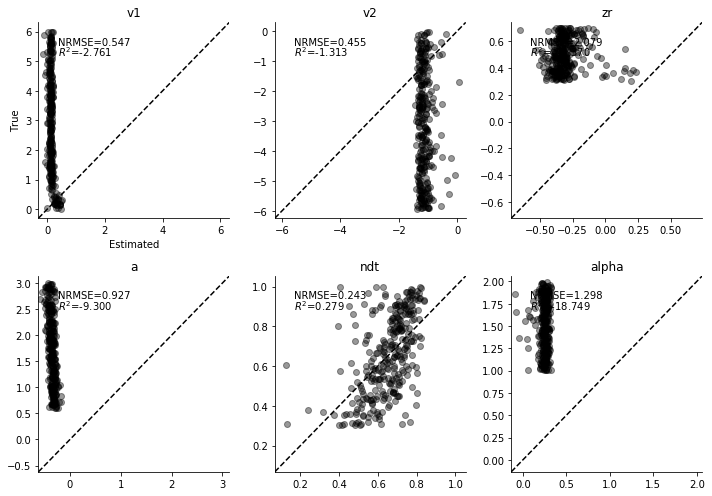

In [32]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 7))

# Train the model

In [14]:
%%time
if train:
    for ep in range(1, epochs+1):
        with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
            losses = train_loop_active(model, optimizer, data_generator, iterations_per_epoch, 
                                batch_size, iterations_per_epoch, p_bar, clip_value=clip_value, 
                                global_step=global_step, transform=transform, ckpt_name='Levy_{}'.format(ep))
            # Plot stuff
            plot_losses(losses, figsize=(10, 4))
            plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 7))
            plot_sbc(model, n_samples_posterior, X_test, theta_test, param_names, figsize=(10, 4))

            # Store checkpoint
            manager.save()

Wall time: 0 ns


# Evaluate the trained model

## Posterior means (recovery)

In [ ]:
%%time
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, 
                      param_names, filename=None, figsize=(10, 6))

## Full posterior (visual inspection)

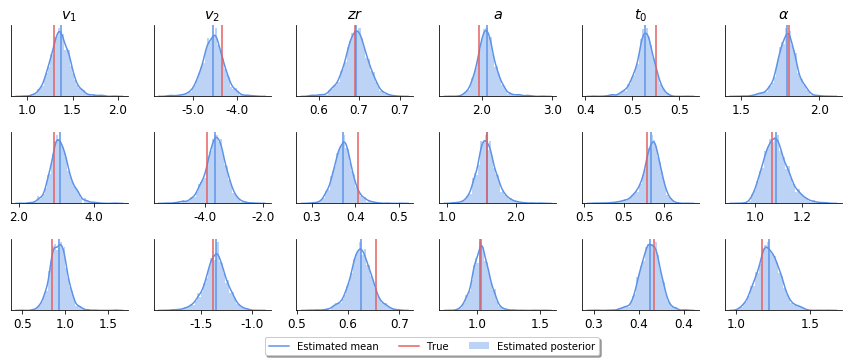

Wall time: 6.79 s


In [87]:
%%time
plot_true_est_posterior(model, n_samples=n_samples_posterior, param_names=param_names, filename='Levy',
                        X_test=X_test2, theta_test=theta_test2, figsize=(12, 5), tight=True)

## Simulation-based calibration

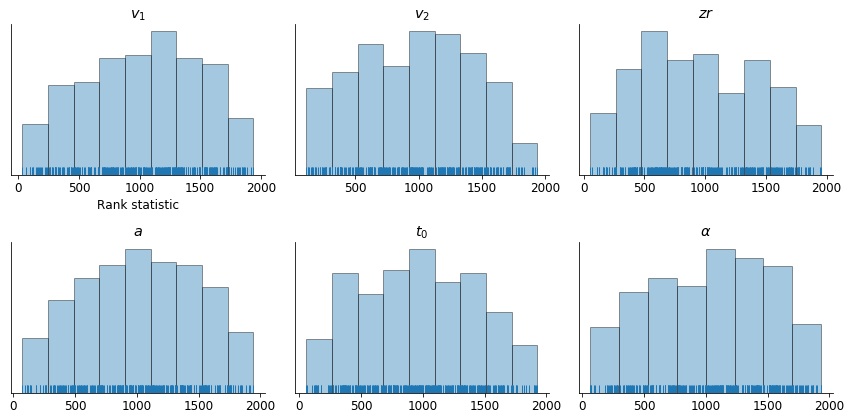

Wall time: 4.18 s


In [82]:
%%time
plot_sbc(model, n_samples_posterior, X_test, theta_test, 
         param_names, figsize=(12, 6), filename='Levy')

## Recovery over all trial sizes

In [55]:
%%time
n_min=100
n_max=1000
with tqdm(total=n_max-n_min, desc='Computation of metrics') as p_bar:
    ns, metrics = compute_metrics(model, param_names, data_generator, n_test, 
                                  n_samples_posterior, p_bar=p_bar, transform=transform, 
                                  n_min=n_min, n_max=n_max)

In [91]:
# Store metrics, as computation is slow
pickle.dump({'trials': ns, 'metrics': metrics}, open('metrics_Levy.p', 'wb'))

### Plot metrics

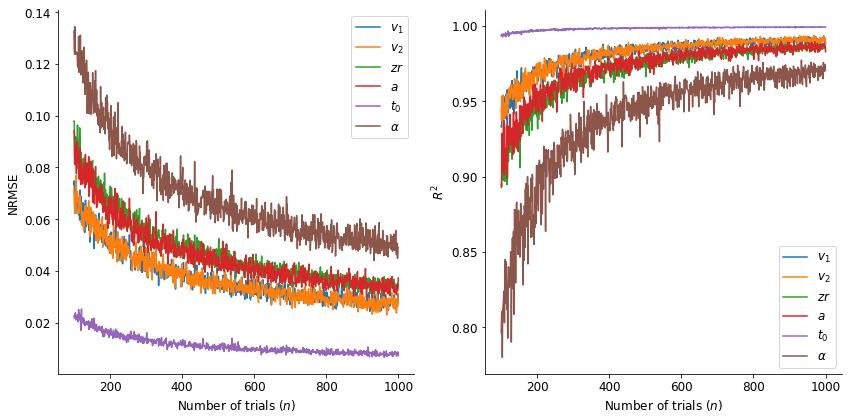

In [89]:
plot_metrics(metrics, ns, param_names, figsize=(12, 6), 
             xlabel=r'Number of trials ($n$)', filename='Levy')

### Plot variance

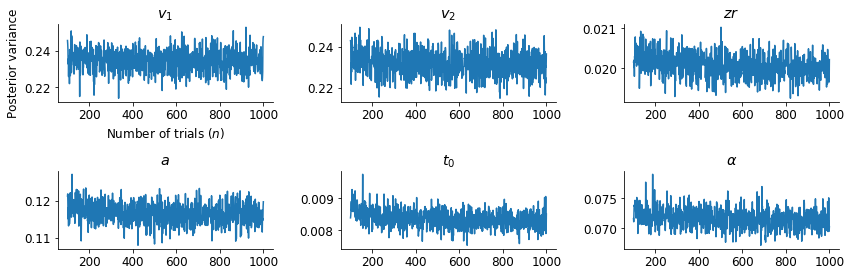

In [76]:
plot_variance(metrics['var'], ns, param_names, figsize=(12, 4), 
              xlabel=r'Number of trials ($n$)', filename='Levy', std=True)

## Speed of inference

In [9]:
n_speed = 1000
X_test3, theta_test3 = simulate_diffusion(1000, parameter_bounds, n_points=1000)
X_test3, theta_test3 = transform(X_test3, theta_test3)

In [13]:
%timeit model.sample(X_test3, n_samples_posterior)

7.39 s ± 37.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
